# 伪检测框标注
1. 使用GroundingDINO推理出的bbox作为伪标签，但是丢弃分类标签
2. 结合图片本身的类别名称，将其转化为COCO格式导出

In [1]:
import os
import glob
import json
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [2]:
class_image_root = "data/dataset/"
name2scientific_path = "data/name2scientific.json"

classes = sorted([
    path.split("/")[-1]
    for path in glob.iglob(f"{class_image_root}/*")
    if os.path.isdir(path)
])

coco_save_path = "data/coco.json"

# Model Parameter
model_config_path = "/home/zhy/pip_hub/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
model_checkpoint_path = "weights/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = .35
TEXT_THRESHOLD = .25
device = "cuda"

# Model

In [3]:
class GroundingDINO:
    def __init__(
        self,
        groundingdino_config,
        groundingdino_checkpoint,
        box_threshold=.35,
        text_threshold=.25,
        device="cuda",
    ):
        """ 初始化GroundingDino
        
        Args:
            groundingdino_config (str): GroundingDINO模型配置文件路径
            groundingdino_checkpoint (str): GroundingDINO模型权重文件路径
            box_threshold (float): 预测框置信度
            text_threshold (float): 文本置信度
            device (str): 运行设备
        """
        from groundingdino.util.inference import Model
        
        self.model = Model(
            groundingdino_config,
            groundingdino_checkpoint,
            device
        )
        
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold
        
    def __call__(self, img, caption):
        """ 推理结果
        
        Args:
            img (np.ndarray): cv读取的图片 (BGR格式)
            caption (str): Prompt 句子
            
        Return: 网络输出的预测边界框，xyxy格式
        """
        out = self.model.predict_with_caption(
            image=img,
            caption=caption,
            box_threshold=self.box_threshold,
            text_threshold=self.text_threshold
        )
        
        return out[0].xyxy

In [4]:
def draw_bbox(image, bbox):
    """ 绘制预测框
    
    Args:
        image (np.ndarray): cv读取的图片 (BGR格式)
        bbox (np.ndarray): 预测框(N, 4), xyxy格式
    """
    image = image.copy()
    bbox = bbox.astype(np.int64)
    for box in bbox:
        cv.rectangle(
            image,
            box[:2],
            box[2:],
            (255, 0, 0),
            2 
        )
        
    return image

In [5]:
model = GroundingDINO(
    groundingdino_config=model_config_path,
    groundingdino_checkpoint=model_checkpoint_path,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=device,
)

/home/zhy/miniconda3/envs/torch2.0/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [12]:
# img = cv2.imread("data/dataset/红腹松鼠/025213bf90b4bad66a3bab921c676dc4.jpeg")
img = cv.imread("data/dataset/东方蝙蝠/cb0e8b825e77d26b731105ba983dce61.jpeg")
out = model(img, "Eastern Pipistrelle")

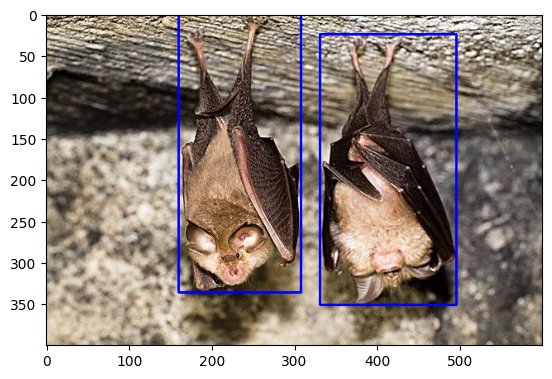

In [13]:
plt.imshow(draw_bbox(img, out)[..., ::-1])

# Make Label

**COCO format**
```python
COCO = {
    "images": [
        {
            # img的唯一ID
            "id": 0,
            "file_name": "1.jpg",
            "height": 123,
            "width": 123
        },
        ...
    ],
    "annotations": [
        {
            # img的唯一ID
            "image_id": 0,
            # bbox的唯一ID
            "id": 0,
            "category_id": 1,
            # 左上宽高
            "bbox": [0, 0, 4, 4],
            "area": 16,
            "segmentation": [0, 0, 1, 1, 2, 2, 3, 3, ...],
            "iscrowd": 0 if "polygon" else 1
        },
        ...
    ],
    "categories": [
        {
            "id": 0,
            "name": "lemon",
        },
        ...
    ]
}
```

In [8]:
with open(name2scientific_path) as f:
    name2scientific = json.load(f)

cls2id = {c: i for i, c in enumerate(classes)}
images = []
annotations = []
categories = [
    {"id": i, "name": c}
    for i, c in enumerate(classes)
]
image_id = 0
annotation_id = 0

In [10]:
image_path_list = glob.glob(f"{class_image_root}/*/*")
for image_path in image_path_list:
    img = cv.imread(image_path)
    H, W, C = img.shape
    # if C == 4:  # 检查图像是否具有4个通道（RGBA格式）
    #     img = cv.cvtColor(img, cv.COLOR_RGBA2RGB)
    cls = image_path.split("/")[-2]
    bbox = model(img, name2scientific[cls])
    for box in bbox:
        x, y, x2, y2 = box.tolist()
        w, h = x2 - x, y2 - y
        annotations.append({
            "image_id": image_id,
            "id": annotation_id,
            "category_id": cls2id[cls],
            "bbox": [x, y, h, w],
            "area": h * w,
            "segmentation": [],
            "iscrowd": 0
        })
        annotation_id += 1
    
    images.append({
        "id": image_id,
        "file_name": image_path.split("/")[-1],
        "height": H,
        "width": W
    })
    image_id += 1
    
print(f"图片共{image_id}张，标定框共{annotation_id}个")

图片共31415张，标定框共40746个


In [23]:
with open(coco_save_path, "w") as f:
    json.dump(
        {
            "images": images,
            "annotations": annotations,
            "categories": categories,
        },
        fp=f
    )